# Opteeq Compter Vision Project - Task B - Image Standardisation and Annotation Pipeline 

This notebook will detail the process of loading and standardizing of recipt images ready to be sent to the GCloud Vision API for labelling. 

The code within this notebook will be tested for functionallity before being put into scripts and packaged as a docker image to be used as an AWS Lambda function. The structure of the notebook is as follows: 

                    1. Things to consider
                    2. Image read and write functions from S3 (boto3)
                    2i. Read and write function testing
                    3. Image standardisation functions using the OpenCV library
                    3i. Image processing function testing

# 1. Things to consider 

    - File naming convention (uuid? timestamp? Annotation files with matching uuid?)
    - Image format ? JPEG only?? 
    - Image size?
    - Image ratio? 
    - Requirements.txt file 

# File naming conventions: 

Image = IMG-{uuid4}-{unix_timestamp}.jpg

# S3 bucket file structure: 

    -bucket_name
        -data
            -unprocessed_data
                -raw_imgs
                    img1
                    img2
                    img3 
            -standardised_annotated_data  
                -img_annotations
                -standardised_imgs
                -json_files
                    -team_member_1
                    -team_member_2
                    -team_member_3 
            -fully_processed_data
                -processed_imgs
                -img_annotations
                -json_files
                

# 2. S3 read/write

We need to load all image files saved in a directory from an AWS S3 bucket. We can perform this task using the low level python sdk boto3.

Images will be read one at a time to deal with AWS Lambda function timeout limits. 

To begin we can use boto3 to access the location of the file in s3 using the bucket name and the file key. Only image extensions compatible with opencv will be accepted ('.JPEG', '.PNG', '.TIFF').  

When writing our information back to S3 we need to save the processed images with a specified file naming convention with a unique id and timestamp. The image will be first saved locally to a temporary directory and then uploaded to the s3 bucket. All images will be saved with the '.jpg' extension. 

In [46]:
import boto3
import botocore 
import cv2
import uuid
import time
import numpy as np

# No longer needed
#def get_image_paths_from_S3(bucket_name: str, key: str) -> 'list(str)': 
#    """
#    List all files in AWS S3 bucket directory
#    :param bucket_name: S3 bucket name
#    :param key: key to S3 bucket directory
#    :return: List of S3 URIs
#    """
    
#    s3_client = boto3.client('s3')
    
#    s3_img_paths = [] # List declaration to store image path locations
    
#    try: # Try to read s3 bucket
#        for obj in s3_client.list_objects_v2(Bucket=bucket_name, Prefix=key)['Contents']: # Loop through bucket directory contents
#            if obj.endswith('.jpeg') or obj.endswith('.png') or obj.endswith('.tiff'):  # Check file extension
#                s3_img_paths.append(obj) # If extension is ok append path to list
#            else: 
#                print("File not a compatible image file, must be of extension '.jpeg', '.png', '.tiff'.") # Else print warning
#    except botocore.exceptions.ClientError as e:
#        print(e.response)
    
#    return s3_img_paths
    

def s3_image_read(bucket_name: str, key: str) -> 'numpy.ndarray':
    """
    Read an image from AWS S3 bucket into a numpy array using OpenCV
    :param bucket_name: Bucket name
    :param key: Key to S3 bucket directory
    :return: Image array
    """
    # Create s3 resource and s3 bucket object using boto3
    s3_resource = boto3.resource('s3')
    bucket = s3_resource.Bucket(bucket_name)
    
    # Try and load an image using boto3 and OpenCV, 
    # Print exception if extension is not OpenCV compatible or there is a boto3 error
    try:
        if key.endswith(".jpg") or key.endswith(".jpeg") or key.endswith(".png") or key.endswith(".tiff"):
            content = bucket.Object(key).get().get('Body').read()
            img = cv2.imdecode(np.asarray(bytearray(content)), cv2.IMREAD_COLOR)
            return img
        else: 
            print('Invalid file extension. Must be .jpg, .jpeg, .png or .tiff')
    except botocore.exceptions.ClientError as e:
        print(e.response)

def generate_unique_info() -> 'Tuple[str, str]':
    """
    Generate unique uuid and unix timestamp for saving files
    :return: Randomly generated uuid and a unix timestamp
    """
    unique_id = str(uuid.uuid4()) # Uuid4 generates a random uuid and we convert it to a string 
    timestamp = str(int(time.time())) # Generates a unix timestamp which we convert to an int and then to string 
    return unique_id, timestamp

def s3_image_write(bucket_name: str, key: str, processed_img: 'numpy.ndarray') -> None:
    """
    Write an image to S3 directory in .jpg format
    :param bucket_name: Bucket name
    :param key: Key to S3 bucket directory
    :param processed_img: Standardised image array
    :param unique_id: Unique randomly generated uuid
    :param timestamp: Unix timestamp
    :return: None
    """
    # Create s3 resource and s3 bucket object using boto3
    s3_resource = boto3.resource('s3')
    bucket = s3_resource.Bucket(bucket_name)
    
    # Function call to generate unique id and timestamp for filename
    unique_id, timestamp = generate_unique_info()
    
    # Write image to local directory using OpenCV
    if not os.path.exists('tmp'):
        os.mkdir('tmp')
    
    filename = 'IMG-{}-{}.jpg'.format(unique_id, timestamp)
    
    cv2.imwrite(os.path.join('tmp', filename), processed_img)
    
    # Try to upload local file to S3 bucket, print error message if upload fails
    try:
        bucket.upload_file(os.path.join('tmp', filename), os.path.join(key, filename))
        print("Image upload success")
    except botocore.exceptions.ClientError as e:
        print(e.response)

#def db_write(table_name: str, processed_img: 'numpy.ndarray', region: str = 'eu-west-3') -> None: 
#    """
#    Write an image to AWS DynamoDB 
#    :param table_name: DynamoDB Table name
#    :param processed_img: Standardised image array
#    :param region: AWS region name where database is located
#    :return: None
#    """
#    
#    # Creation of client for dynamodb
#    dyndb_client = boto3.client('dynamodb', region_name=region)
#    try: 
#        response = dyndb_client.put_item(
#            TableName = table_name,
#            Item={
#
#            }
#            )
#    except: botocore.exceptions.ClientError as e:
#        print(e.response) 

# 2a. Read write function testing

In [44]:
# Replace bucket name key and region for testing
s3_bucket_name = 'dsti-opteeq-test'
key = 'unprocessed-images/IMG_20210629_195614.jpg'
region = 'eu-west-3'

# (i) S3 image read function testing

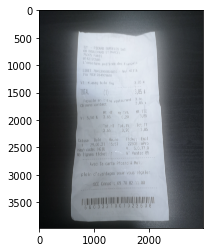

In [50]:
# S3 Image read function testing
import matplotlib.pyplot as plt
img = s3_image_read(s3_bucket_name, key)

plt.imshow(img)

# (ii) Unique id function testing

In [47]:
# UUID and unix timestamp function testing
generate_unique_info()

('ce276081-85db-4f24-bd00-1b867126301c', '1626289659')

# (iii) S3 image write function testing

In [49]:
# S3 image write testing
outkey = 'processed-images'
s3_image_write(s3_bucket_name, outkey, img)

Image upload success


# 3. Image standardisation

During image standardisation we need to perform several operations to prepare images for annotation using the GCloud Vision API. This includes orienting the image correctly, ensuring that images have a minimum size and that the ratio of the images is suitable. 

Google Vision API reccommends 1067 x 768 image size for document text detection as OCR requires more resolution to detect characters.

Image resize code: 


Image angle detection code: 
https://stackoverflow.com/questions/58010660/detect-image-orientation-angle-based-on-text-direction/58020893

In [79]:
import cv2
import numpy as np

def image_resize(img: 'numpy:ndarray', width: int = None, height: int = None, inter = cv2.INTER_AREA) -> 'numpy.ndarray':
    """
    Resize an image keeping the same aspect ratio. 
    :param img: Image array
    :param width: Desired image width
    :param height: Desired image height
    :param inter: OpenCV interpolation function
    :return: Resized image array
    """
    
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = img.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return img

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized_img = cv2.resize(img, dim, interpolation = inter)

    # return the resized image
    return resized_img


def check_image_size(img: 'numpy.ndarray') -> 'numpy.ndarray': 
    """
    Check image size and call image resize function using either height or width if either dimension
    smaller than 1067x768 and call resize_image function using the parameter that is too small as the input. 
    :param img: Image array
    :return: None
    """
    # Height and width reccommended by GCloud Vision API 
    height = 1067
    width = 768
    
    # Get image height and width
    (h, w) = img.shape[:2]
    
    # Resize image if needed and return resized or original image 
    if h < height and w < width:
        print("Image height and width too small, resizing image...")
        return image_resize(img, height=1067)
    elif h < height and w >= width: 
        print("Image height too small, image width ok, resizing image...")
        return image_resize(img, height=1067)
    elif h >= height and w < width:
        print("Image height ok, image width too small, resizing image...")
        return image_resize(img, width=768)
    else: 
        return img
    

def detect_angle(img: 'numpy.ndarray') -> int:
    """
    Text orientation detection.  
    :param img: Image array
    :return: angle corresponding to orientation, 90=desired orientation
    """
    # Convert image to grayscale and perform a gaussian blur 
    # Then use adaptive threshhold to obtain a binary image
    mask = np.zeros(img.shape, dtype=np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    adaptive = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,15,4)
    
    
    # Find contours
    cnts = cv2.findContours(adaptive, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    # Filter using contour area to remove noise particles and large borders
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 45000 and area > 20:
            cv2.drawContours(mask, [c], -1, (255,255,255), -1)
    
    # Pass contours that pass the filter onto a mask 
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    h, w = mask.shape
    
    # To determine the angle we split the image in half based the dimensions
    # If width > height then it must be a horizontal image so we split in half vertically
    # If height > width then it must be a vertical image so we split in half horizontally
 
    # Horizontal
    if w > h:
        left = mask[0:h, 0:0+w//2]
        right = mask[0:h, w//2:]
        left_pixels = cv2.countNonZero(left)
        right_pixels = cv2.countNonZero(right)
        return 0 if left_pixels >= right_pixels else 270 # Changed 180 to 270
    
    # Vertical
    else:
        top = mask[0:h//2, 0:w]
        bottom = mask[h//2:, 0:w]
        top_pixels = cv2.countNonZero(top)
        bottom_pixels = cv2.countNonZero(bottom)
        return 90 if bottom_pixels >= top_pixels else 180 # Changed 270 to 180
    
def rotate_image(img: 'numpy:ndarray') -> 'numpy.ndarray': 
    """
    Image rotation function using output of detect_angle().
    :param img: Image array
    :return: Rotated image array
    """
    # Get image angle using angle detection function 
    img_angle = detect_angle(img)
    
    # Rotate image to 90 degrees 
    if img_angle == 90:
        return img
    elif img_angle == 0: 
        return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif img_angle == 270:
        return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    elif img_angle == 180:
        return cv2.rotate(img, cv2.ROTATE_180)

90
Image height and width too small, resizing image...
(1067, 801, 3)


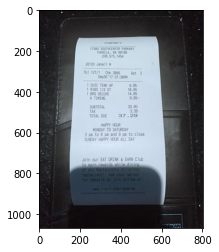

In [74]:
img = rotate_image(img)
rotated_img = check_image_size(img)
plt.imshow(rotated_img)
print(rotated_img.shape)

# 3a. Testing image processing functions

# (i) Image resize

image shape: (450, 338, 3)
<class 'numpy.ndarray'>


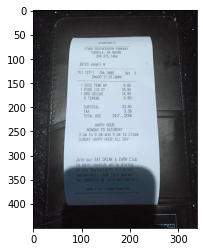

In [52]:
import cv2
import os
import matplotlib.pyplot as plt

#Local image load
img_path = os.path.abspath('data/1192-receipt.jpg') #Get absolute image path 
img = cv2.imread(img_path) # Read image from local directory for testing
#img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE) # Read grayscale image 

print("image shape: {}".format(img.shape)) # Return image dimensions
print(type(img))

plt.imshow(img) # Display image using matplotlib

(1022, 768, 3)


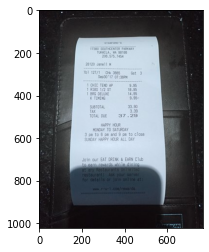

In [53]:
# Test image resize function
resized_img = image_resize(img, height = 1024, width = 768) # Set height to 1024 x 768
print(resized_img.shape)
plt.imshow(resized_img)

# (ii) Angle detection testing

In [86]:
# Rotate original image for angle detection rotation function testing
# Rotate image 90 degrees clockwise and write image
img_rotate_90_clockwise = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
cv2.imwrite(os.path.abspath('data') + '/1192_receipt_rotate_90_clockwise.jpg', img_rotate_90_clockwise)

# Rotate image 90 degrees counterclockwise and write image
img_rotate_90_counterclockwise = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
cv2.imwrite(os.path.abspath('data') + '/1192_receipt_rotate_90_counterclockwise.jpg', img_rotate_90_counterclockwise)

# Rotate image 180 degrees and write image
img_rotate_180 = cv2.rotate(img, cv2.ROTATE_180)
cv2.imwrite(os.path.abspath('data') + '/1192_receipt_rotate_180.jpg', img_rotate_180)

True

In [87]:
def angle_detection_test(img_paths):
    # Loop through image filenames and contrust the absolute path for each image
    # Read image using OpenCV and run angle detection function, printing the filename and the angle of orientation
    for path in img_paths: 
        img = cv2.imread(os.path.abspath('data') + path)
        angle = detect_angle(img)
        print("{}: {} degrees".format(path, angle))

In [89]:
# Get image paths of same image with different orientations
img_paths = ['/1192-receipt.jpg', '/1192_receipt_rotate_90_counterclockwise.jpg', '/1192_receipt_rotate_90_clockwise.jpg', '/1192_receipt_rotate_180.jpg']

# Run angle detection function
angle_detection_test(img_paths)

/1192-receipt.jpg: 90 degrees
/1192_receipt_rotate_90_counterclockwise.jpg: 180 degrees
/1192_receipt_rotate_90_clockwise.jpg: 90 degrees
/1192_receipt_rotate_180.jpg: 0 degrees


# (iii) Image rotate function testing

In [90]:
# Helper functions
def multi_img_plot(imgs): 

    fig = plt.figure(figsize=(9, 13))
    
    columns = 4
    rows = 5
    
    for i in range(1,len(imgs)):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
    plt.show()
    
def get_img_paths_local():

    img_paths = []
    
    paths = os.listdir(os.path.abspath('data'))
    
    for i, path in enumerate(paths):
        if path.endswith('.jpg'):
            img_paths.append(path)
            
    return img_paths

def img_processing_test(img_paths): 

    processed_imgs = []
    
    for i, path in enumerate(img_paths):
        im_path = os.path.abspath('data/' + path)
        img = cv2.imread(im_path)
        rotated_img = rotate_image(img)
        resized_img = image_resize(rotated_img)
        processed_imgs.append(resized_img)

    return processed_imgs

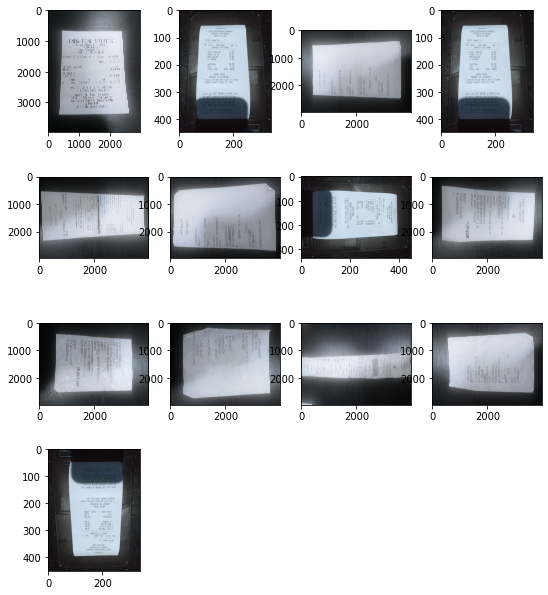

In [91]:
# Testing of image processing functions
img_paths = get_img_paths_local()

original_imgs = []

for i, path in enumerate(img_paths):
    im_path = os.path.abspath('data/' + path)
    img = cv2.imread(im_path)
    original_imgs.append(img)

multi_img_plot(original_imgs)

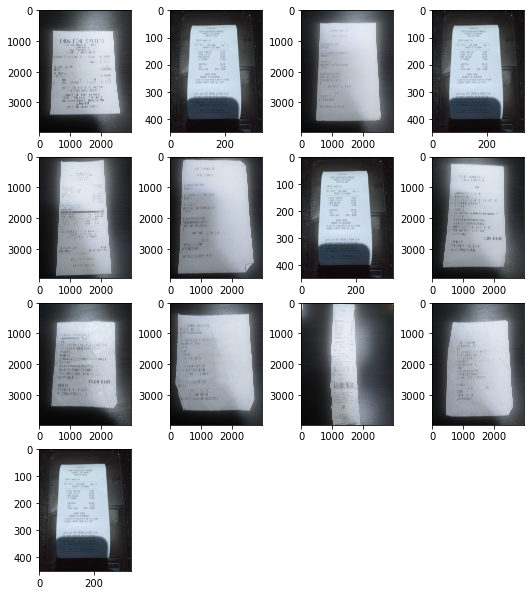

In [92]:
imgs = img_processing_test(img_paths)
# Plot processed images
multi_img_plot(imgs)

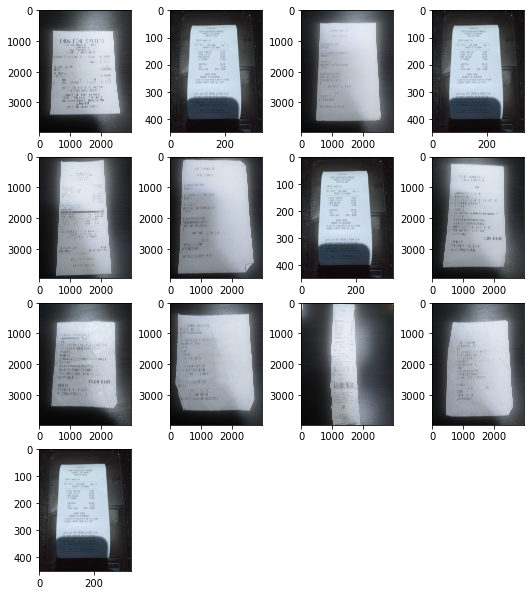

In [93]:
# Plot processed images
multi_img_plot(imgs)

# (iii) Image rotate function testing

In [94]:
# Helper functions
def multi_img_plot(imgs): 

    fig = plt.figure(figsize=(9, 13))
    
    columns = 4
    rows = 5
    
    for i in range(1,len(imgs)):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
    plt.show()
    
def get_img_paths_local():

    img_paths = []
    
    paths = os.listdir(os.path.abspath('data'))
    
    for i, path in enumerate(paths):
        if path.endswith('.jpg'):
            img_paths.append(path)
            
    return img_paths

def img_processing_test(img_paths): 

    processed_imgs = []
    
    for i, path in enumerate(img_paths):
        im_path = os.path.abspath('data/' + path)
        img = cv2.imread(im_path)
        rotated_img = rotate_image(img)
        resized_img = image_resize(rotated_img)
        processed_imgs.append(resized_img)

    return processed_imgs

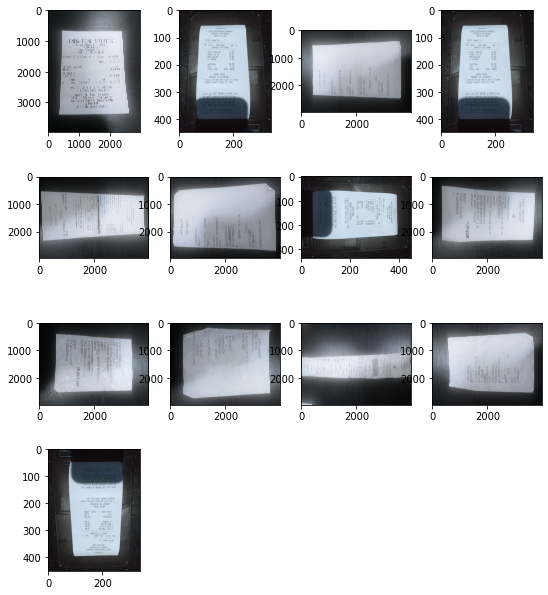

In [95]:
# Testing of image processing functions
img_paths = get_img_paths_local()

original_imgs = []

for i, path in enumerate(img_paths):
    im_path = os.path.abspath('data/' + path)
    img = cv2.imread(im_path)
    original_imgs.append(img)

multi_img_plot(original_imgs)

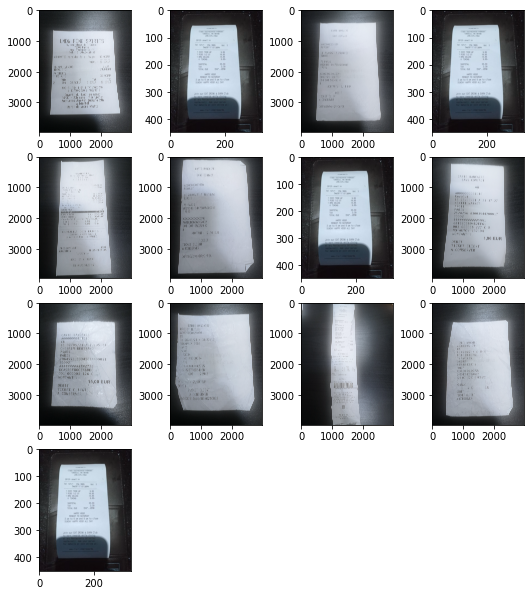

In [82]:
imgs = img_processing_test(img_paths)
# Plot processed images
multi_img_plot(imgs)